# UFO Sightings

_Where should we go to maximize our chances of a UFO Sighting?_


Original data available from [Kaggle.com](https://www.kaggle.com/datasets/NUFORC/ufo-sightings)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

A real data analysis project requires a lot of investigation and looking for complex patterns. 

We are going to look at the UFO data set from Kaggle, and try to figure out where we should go if we want to the highest chance of meeting. I mean, we cannot all wait until [April 5 2063 in Bozeman, Montana](https://en.wikipedia.org/wiki/Vulcan_(Star_Trek)#:~:text=On%20April%205%2C%202063%2C%20Vulcans,s%20first%20warp%2Dcapable%20starship.)!



## Load and format the data

In [2]:
ufo_df = pd.read_csv("datasets/ufo.csv")
ufo_df['datetime'] = pd.to_datetime(ufo_df['datetime'].str.replace('24:00', '0:00'))
ufo_df['date posted'] = pd.to_datetime(ufo_df['date posted'])
ufo_df.columns = [c.strip() for c in ufo_df.columns]
ufo_df['latitude'] = pd.to_numeric(ufo_df['latitude'], errors='coerce')
ufo_df['longitude'] = pd.to_numeric(ufo_df['longitude'], errors='coerce')

ufo_df.head()

/var/folders/g3/ht715qhj3cs5jcw0fnkfbh1c0000gp/T/ipykernel_75389/48040896.py:1: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  ufo_df = pd.read_csv("datasets/ufo.csv")


,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,2004-04-27,29.883056,-97.941111
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.384210,-98.581082
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,2004-01-17,28.978333,-96.645833
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,2004-01-22,21.418056,-157.803611


## Are UFO sightings increasing or decreasing? Let's find out!

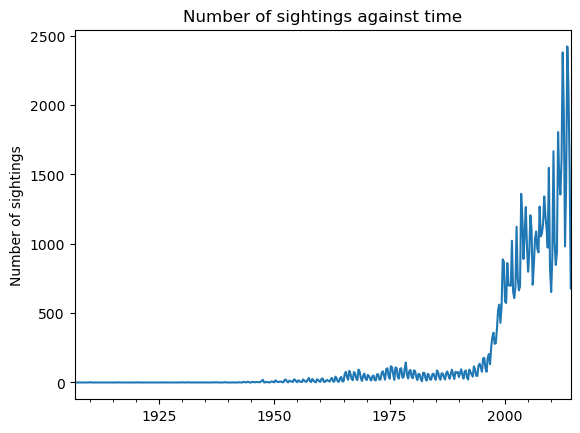

In [3]:
ufo_df.set_index('datetime').resample('Q')['shape'].count().plot()
plt.ylabel('Number of sightings')
plt.xlabel('')
plt.title('Number of sightings against time');

They are definitely increasing against time!

## Where are the UFO sighting hotspots?

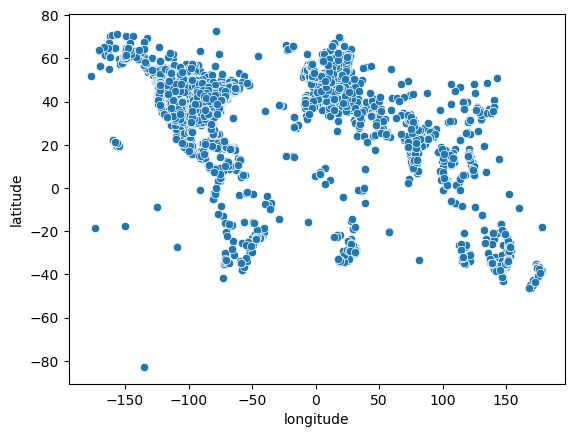

In [4]:
sns.scatterplot(data=ufo_df, x='longitude', y='latitude');

We can use some libraries that will plot this on a world map, but we can see the overall shape already! We see that North America, Europe, Australian, New Zealand, South Africa, and India are well visited.

We can see which countries are most visited:

In [5]:
ufo_df['country'].value_counts(normalize=True, dropna=False).reset_index()

,index,country
0,us,0.810561
1,NaN,0.120375
2,ca,0.037345
3,gb,0.023714
4,au,0.006697
5,de,0.001307


Or more visually

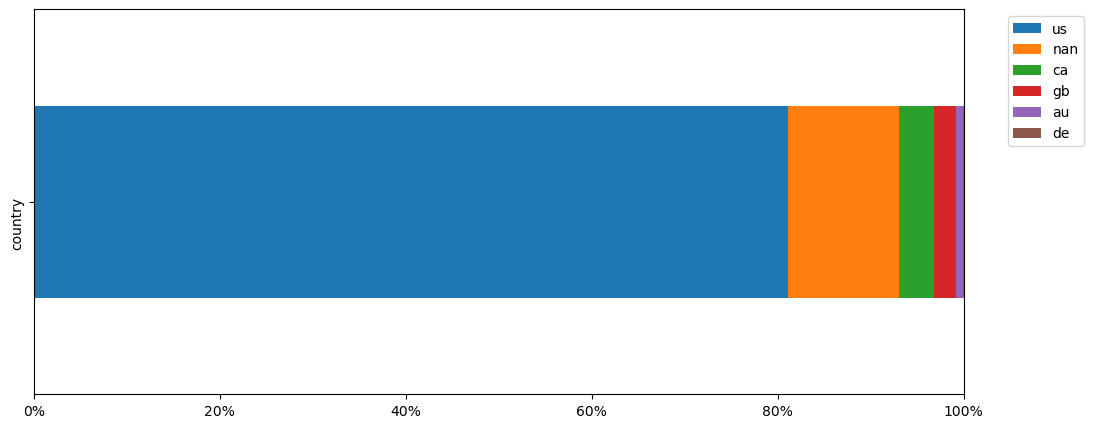

In [6]:
ufo_df['country'].value_counts(normalize=True, dropna=False).to_frame().T.plot(
    kind='barh', stacked=True, rot=90, figsize=(12, 5)
)
plt.xlim(0, 1)
plt.margins(y=0)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))

We can see that there are a lot of countries missing. New Zealand is obvious on the map, but isn't listed as as country on the list!

We see that regardless of where the missing countries belong to, the country with the most sightings is the US. However, the US is absolutely huge, compared to say Belguim. If we were trying to maximize our chance of seeing a UFO, we should look for the area with the highest concentration of sightings.

Let's look within 1 degree (that is 0.5 degrees either side) and find the point with the most sightings within 1 square degree. At the equator, 1 sq degree is 111 km by 111 km

In [7]:
def num_rows_in_window(
    longitude:float, 
    latitude:float, 
    df:pd.DataFrame, 
    window_size_in_deg:float=1.0
) -> int:
    """Finds the densest spot.
    
    Is a simplifed example, as it works in square degrees. The size of a square degree changes
    as you move North or South. A more correct version would use distance, and correct for the 
    latitude.
    
    Also doesn't correctly capture points within 1 degree of
    - the 180 degree longitude (near the dateline)
    - within 1 degree of the poles
    due to wrapping effect. Sightings are low in these places, so the effect on the outcome
    is minimal
    """
    min_lat, max_lat = latitude - window_size_in_deg / 2, latitude + window_size_in_deg / 2
    min_long, max_long = longitude - window_size_in_deg / 2, longitude + window_size_in_deg / 2
    
    mask = df['longitude'] >= min_long
    mask &= df['longitude'] <= max_long
    mask &= df['latitude'] >= min_lat
    mask &= df['latitude'] <= max_lat
    return sum(mask)

In [8]:
ufo_df['num_nearby'] = ufo_df.apply(lambda row: num_rows_in_window(longitude=row.longitude, latitude=row.latitude, df=ufo_df), axis=1)

Let's look at the top 10 sites:

In [9]:
ufo_df[['city', 'country', 'latitude', 'longitude', 'num_nearby']].drop_duplicates().sort_values(by='num_nearby', ascending=False).head(10)

,city,country,latitude,longitude,num_nearby
13617,cerritos,us,33.858333,-118.063889,2577
6546,cypress,us,33.816944,-118.036389,2575
33492,la palma,us,33.846389,-118.045833,2572
5159,norwalk,us,33.902222,-118.080833,2559
118,alhambra,us,34.095278,-118.126111,2558
64784,downey (north american aviation),us,33.940000,-118.131667,2558
3428,downey,us,33.940000,-118.131667,2558
23304,santa fe springs,us,33.947222,-118.084444,2556
9910,bell gardens,us,33.965278,-118.150556,2546
28319,temple city,us,34.107222,-118.056944,2544


It seems Cerritos, California (or LA in general!) is the place to be!